# Đồ án cuối kỳ

# Môn: Xử lý dữ liệu lớn
# Học kỳ 1 - Năm học 2022-2023

---

# Sinh viên:
# Ngô Hữu Lễ-  51800571
# Phạm Nhật Anh - 51900646
# Nguyễn Duy Đông - 52000749
# Huỳnh Đình Long - 52000777

---

# Giảng viên: Th.S. Nguyễn Thành An


# Cài đặt PySpark

In [3]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
# !cp drive/MyDrive/tmp/spark-3.1.1-bin-hadoop3.2.tgz .
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

import findspark
findspark.init()

# Yêu cầu

## Spark Context

In [6]:
from pyspark import SparkContext
from pyspark.sql import SQLContext

sc = SparkContext("local", 'CK')
sqlc = SQLContext(sc)

In [7]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
import numpy as np
from pyspark.mllib.linalg import Vectors

## Câu 1: Giảm số chiều với SVD

### Hiển thị


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
if os.path.exists('/content/gdrive/MyDrive/BigData/oxford_pet3_train.csv'):
  data = sc.textFile('/content/gdrive/MyDrive/BigData/oxford_pet3_train.csv')

In [ ]:
vectors = np.array([[float(i) for i in range(49152)]])
title = np.empty(0)
for i in range(15):
  a = data.collect()[i]
  row = [float(i) for i in a.split(',')[2:]]
  title = np.append(title, a.split(',')[1])
  vectors = np.append(vectors, [row], 0)

In [ ]:
print(vectors)

[[0.0000e+00 1.0000e+00 2.0000e+00 ... 4.9149e+04 4.9150e+04 4.9151e+04]
 [5.0000e+00 3.0000e+00 3.0000e+00 ... 3.0000e+00 4.0000e+00 7.0000e+00]
 [6.0000e+00 1.7000e+01 1.0000e+00 ... 1.3600e+02 1.5700e+02 9.0000e+01]
 ...
 [2.4400e+02 2.0600e+02 4.3000e+01 ... 1.1500e+02 1.7500e+02 6.2000e+01]
 [1.0000e+00 0.0000e+00 0.0000e+00 ... 8.3000e+01 6.9000e+01 6.1000e+01]
 [1.3900e+02 1.2100e+02 1.0900e+02 ... 7.9000e+01 1.0500e+02 4.3000e+01]]


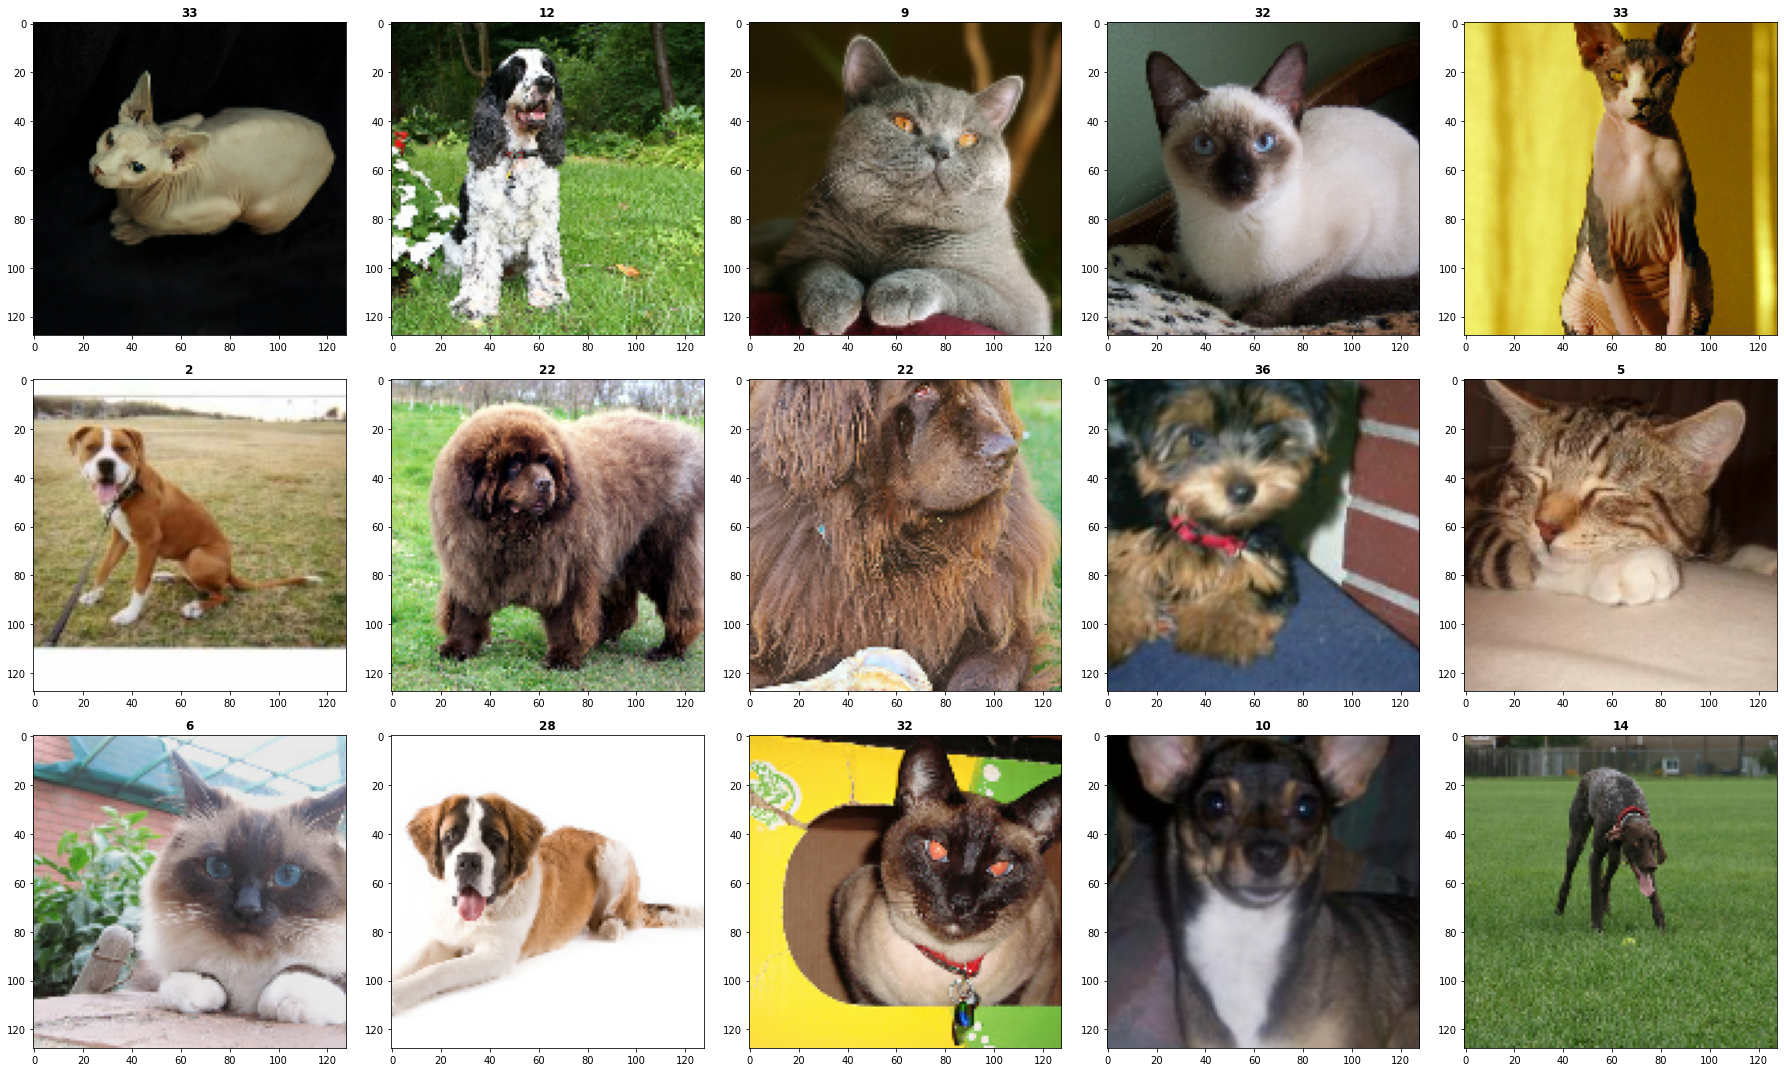

In [ ]:
plt.figure(figsize=(25, 15))
for i in range(15):
  img = np.array(np.reshape(vectors[i+1], (128, 128, 3)), dtype=np.uint8)
  plt.subplot(3, 5, i+1)
  plt.imshow(img)
  plt.title(title[i] ,fontweight ="bold")   
plt.gcf().set_facecolor("white")
plt.tight_layout()

### Giảm số chiều tập train

In [ ]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix

In [ ]:
data = sc.textFile('/content/gdrive/MyDrive/BigData/oxford_pet3_train.csv')

In [ ]:
# lấy toàn bộ vector ảnh
def preprocessLine(x):
  items = x.strip().split(',')[:]
  region = Vectors.dense([float(i) for i in items[2:]])
  return region

vector = data.map(preprocessLine)

In [ ]:
X = csr_matrix(vector.collect())
svd = TruncatedSVD(n_components=8200)
svd.fit(X)

TruncatedSVD(n_components=8200)

In [ ]:
# result = U * Sigma = X.V, VT = svd.components_
result = svd.transform(X)
print(result)

[[ 7.88064854e+03  4.85287335e+03 -5.07194960e+03 ... -1.73109865e+02
  -1.73290893e+02  2.08378284e+02]
 [ 2.35963016e+04  9.65145386e+03  1.96096770e+03 ...  1.87385598e+01
   6.84348086e+00  3.22928398e+01]
 [ 1.72825514e+04  6.49180151e+03  3.82531112e+02 ... -1.14868165e+01
  -4.90806310e+00  3.61088229e+01]
 ...
 [ 2.68161594e+04 -1.74913816e+03 -3.19152093e+03 ...  3.01696738e+00
   5.85764141e+01 -3.07207710e-01]
 [ 2.15417701e+04  1.12857801e+03  1.85057141e+03 ...  3.18630199e+01
  -5.34055351e+00  8.40891292e+00]
 [ 2.90705136e+04 -2.78306320e+03 -6.61348043e+03 ... -1.56744109e+02
  -1.83027082e+02  2.66412758e+01]]


In [ ]:
def setDF(dataset, result, filepath):
  def preprocessLine(x):
    items = x.strip().split(',')[:]
    region = [int(i) for i in items[0:2]]
    return region

  dfTamp = dataset.map(preprocessLine).collect()

  columns = StructType([StructField('index', IntegerType(), True),
                        StructField('types', IntegerType(), True)])
  df1 = sqlc.createDataFrame(data = dfTamp, schema = columns)

  df2 = sqlc.createDataFrame(data = result.tolist())

  df2 = df2.coalesce(1).withColumn("index", monotonically_increasing_id())
  df = df1.join(df2, on=['index'], how = "inner")

  df.orderBy('index').write.mode('overwrite').csv(path = filepath,
              header=False, 
              sep=',')

In [ ]:
setDF(data, result, '/content/gdrive/MyDrive/BigData/r_oxford_pet3_train.csv')

### Giảm số chiều tập test

In [ ]:
data = sc.textFile('/content/gdrive/MyDrive/BigData/oxford_pet3_test.csv')

In [ ]:
# lấy toàn bộ vector ảnh
def preprocessLine(x):
  items = x.strip().split(',')[:]
  region = Vectors.dense([float(i) for i in items[2:]])
  return region

vector = data.map(preprocessLine)

In [ ]:
# result = U * Sigma, VT = svd.components_
X = csr_matrix(vector.collect())
result = svd.transform(X)
print(result)

[[ 2.50198333e+04 -4.22082857e+03 -2.24259427e+03 ...  2.55512429e+02
   1.31675349e+02 -7.50095792e+01]
 [ 1.15617606e+04  1.97978577e+02  1.54347243e+03 ...  1.31044893e+02
  -4.97397066e+01 -1.29452632e+02]
 [ 2.65435850e+04  3.98905714e+03 -4.18935122e+03 ... -5.30895413e+01
  -8.87870681e+01 -1.00951128e+00]
 ...
 [ 2.27900277e+04  6.88244248e+02 -7.14340647e+03 ... -1.39019779e+02
   4.70823551e+01 -9.45495710e+01]
 [ 2.20549204e+04  5.55956671e+03  1.99447241e+03 ... -1.34038040e+01
   7.37436151e+01 -1.36797056e+02]
 [ 1.55122286e+04  6.12205647e+03  1.61108095e+03 ...  4.16239527e+00
  -1.15511002e+02  5.38899419e+01]]


In [ ]:
setDF(data, result, '/content/gdrive/MyDrive/BigData/r_oxford_pet3_test.csv')

## Câu 2: Khuyến nghị sản phẩm với Collaborative Filtering

In [8]:
schema = StructType() \
          .add("index", IntegerType(), True) \
          .add("user", IntegerType(), True) \
          .add("item", IntegerType(), True) \
          .add("rating", FloatType(), True)
          
df = sqlc.read.option("header",True).schema(schema).csv("/content/gdrive/MyDrive/BigData/ratings2k.csv")

In [9]:
df.show()
df.printSchema()

+-----+----+----+------+
|index|user|item|rating|
+-----+----+----+------+
|    0|  73|  52|   4.0|
|    1|  36| 239|   3.0|
|    2|  72|  26|   1.0|
|    3|  59| 430|   2.5|
|    4|  72| 284|   3.0|
|    5|  36| 277|   3.0|
|    6|  72| 426|   4.0|
|    7|  18| 163|   3.0|
|    8|  67|  93|   4.0|
|    9|  59|  22|   3.5|
|   10|   8| 174|   2.0|
|   11|   5| 149|   2.0|
|   12|  26| 322|   3.5|
|   13|   8| 416|   4.0|
|   14|  31|  25|   2.0|
|   15|  41|  83|   2.0|
|   16|  25| 321|   3.0|
|   17|  47| 193|   3.0|
|   18|   9| 455|   4.0|
|   19|  43| 216|   3.5|
+-----+----+----+------+
only showing top 20 rows

root
 |-- index: integer (nullable = true)
 |-- user: integer (nullable = true)
 |-- item: integer (nullable = true)
 |-- rating: float (nullable = true)



In [10]:
matrix = df.groupBy("user").pivot("item").sum("rating").orderBy('user')
matrix.show(5)

+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----

In [11]:
matrix.count()

74

In [12]:
matrix_rdd = matrix.rdd.map(lambda x: x).collect()
print(matrix_rdd)

[Row(user=1, 0=None, 1=None, 2=None, 3=None, 4=None, 5=None, 6=None, 7=None, 8=None, 9=None, 10=None, 11=None, 12=None, 13=None, 14=None, 15=None, 16=None, 17=None, 18=None, 19=None, 20=None, 21=None, 22=None, 23=None, 24=None, 25=None, 26=None, 27=None, 28=None, 29=None, 30=None, 31=None, 32=None, 33=None, 34=None, 35=None, 36=None, 37=None, 38=None, 39=None, 40=None, 41=None, 42=None, 43=None, 44=None, 45=None, 46=None, 47=None, 48=None, 49=None, 50=None, 51=None, 52=None, 53=None, 54=None, 55=None, 56=None, 57=None, 58=None, 59=None, 60=None, 61=None, 62=None, 63=None, 64=None, 65=None, 66=None, 67=None, 68=None, 69=None, 70=None, 71=None, 72=None, 73=None, 74=None, 75=None, 76=None, 77=None, 78=None, 79=None, 80=None, 81=None, 82=None, 83=None, 84=None, 85=None, 86=None, 87=None, 88=None, 89=None, 90=None, 91=None, 92=None, 93=None, 94=None, 95=None, 96=None, 97=None, 98=None, 99=None, 100=None, 101=None, 102=None, 103=None, 104=None, 105=None, 106=None, 107=None, 108=None, 109=Non

In [13]:
# a dictionary matrix_basket = {user: {item: rating}}
matrix_basket = {}
all_items = []
all_users = []
for user in range(len(matrix_rdd)):
  matrix_basket[user] = {}
  for i in range(0,len(matrix_rdd[user])-1):
    if i not in all_items:
      all_items.append(i)
    if matrix_rdd[user][i+1] == None:
      continue
    matrix_basket[user][i] = matrix_rdd[user][i+1]

all_users = list(matrix_basket.keys())
print(all_items)
print(matrix_basket)
print(len(matrix_basket))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [14]:
keys = list(matrix_basket.keys())[-4:]
values = list(matrix_basket.values())[-4:]

last_4_users = {}
for i in range(4):
  last_4_users[keys[i]] = values[i]

print(last_4_users)
print(len(last_4_users))
print(len(matrix_basket))

{70: {1: 2.0, 4: 4.0, 5: 4.0, 8: 5.0, 10: 4.0, 11: 5.0, 12: 4.0, 15: 5.0, 17: 4.0, 18: 4.0, 25: 4.0, 26: 1.0, 29: 4.0, 32: 1.0, 34: 4.0, 36: 5.0, 42: 4.0, 44: 1.0, 45: 4.0, 46: 3.0, 49: 3.0, 50: 4.0, 52: 3.0, 59: 4.0, 60: 2.0, 62: 4.0, 67: 4.0, 68: 3.0, 72: 2.0, 77: 4.0, 80: 4.0, 81: 4.0, 82: 4.0, 83: 1.0, 85: 3.0, 91: 3.0, 93: 4.0, 94: 2.0, 100: 2.0, 101: 2.0, 103: 1.0, 106: 1.0, 107: 4.0, 108: 2.0, 110: 2.0, 112: 4.0, 115: 1.0, 122: 3.0, 123: 5.0, 124: 3.0, 128: 1.0, 130: 4.0, 131: 3.0, 139: 3.0, 140: 3.0, 141: 2.0, 144: 5.0, 145: 4.0, 153: 3.0, 154: 4.0, 157: 3.0, 159: 3.0, 161: 3.0, 163: 5.0, 164: 3.0, 165: 1.0, 166: 2.0, 175: 1.0, 176: 5.0, 178: 4.0, 184: 4.0, 185: 3.0, 186: 3.0, 188: 5.0, 191: 3.0, 193: 4.0, 196: 5.0, 197: 3.0, 199: 5.0, 200: 4.0, 202: 3.0, 204: 4.0, 207: 2.0, 208: 4.0, 210: 2.0, 211: 3.0, 214: 3.0, 216: 2.0, 217: 4.0, 218: 4.0, 220: 2.0, 222: 4.0, 224: 3.0, 225: 2.0, 232: 4.0, 233: 2.0, 238: 2.0, 239: 5.0, 240: 2.0, 241: 3.0, 246: 3.0, 249: 2.0, 251: 5.0, 255: 3

In [15]:
import math
import numpy as np

def sim(matrix, user1, user2):
  matched = []
  for item in matrix[user1].keys():
    if item in matrix[user2].keys():
      matched.append(item)
  
  x = []
  y = []

  for i in matched:
    x.append(matrix[user1][i])
    y.append(matrix[user2][i])

  f = (lambda i, j: i - j)
  x = f(x, np.mean(x))
  y = f(y, np.mean(y))

  # Pearson Correlation Coefficient
#  numerator = (lambda x, y : x*y)
#  denominator = (lambda x: x*x)

  def denominator(x):
    return [i*i for i in x]

  def numerator(x, y):
    rs = []
    for i in x:
      for j in y:
        rs.append(i*j)
    return rs

  a, b, c = 0, 0, 0
  for i in denominator(x):
    a += i

  for i in denominator(y):
    b += i
  d = math.sqrt(a) * math.sqrt(b)

  mul = x*y
  for i in mul:
    c += i

  d = math.sqrt(a) * math.sqrt(b)
  if d == 0:      
    return 0
  similarity = c/ d
  return similarity

In [16]:
def most_similar_user(matrix, user, n=70):
  similarity = {}
  for p in matrix.keys():
    similarity[p] = sim(matrix, user, p)
  sorted_list = sorted(similarity.items(), key = lambda kv:(kv[1], kv[0]))
  return sorted_list[-n:]

In [17]:
def pred_rating(matrix, user):
  similar_user = most_similar_user(matrix, user)
  predictions = {}
  for i in all_items:
    num = 0
    den = 0
    for user_ in similar_user:
      if i in matrix[user_[0]].keys():
        num += matrix[user_[0]][i] * user_[1]
        den += user_[1]
    if den == 0:
      continue
    predictions[i] = float(num/den)
  return predictions 

In [18]:
import copy
training_data = copy.deepcopy(matrix_basket)

In [19]:
predicted = {}
for user in last_4_users:
  predicted[user] = pred_rating(training_data, user)

for i in predicted.values():
  print(i)

{0: 3.626013674769005, 1: 2.869309929767565, 2: 3.983705246103106, 3: 3.4463212439161146, 4: 4.1742840984265115, 5: 3.3631855920154603, 6: 3.0, 7: 3.3517936149059318, 8: 4.46874922568161, 9: 2.8552554971032427, 10: 4.129050529471312, 11: 4.095909094089156, 12: 4.096581662941083, 13: 3.2435547702553067, 14: 1.0, 15: 3.9666567682692215, 16: 3.6936132278130676, 17: 3.69129486590645, 18: 3.929776554408178, 19: 3.0, 20: 2.853680821658913, 21: 3.699138421858319, 22: 3.8408797909148125, 23: 3.0, 24: 3.4871019617195516, 25: 3.93990321837772, 26: 2.748521372238689, 27: 3.0, 28: 4.6516353847581575, 29: 3.73599083683916, 30: 4.0, 31: 2.5173301294980353, 32: 1.3417442470637515, 33: 3.342378674998455, 34: 4.0786284638479025, 35: 3.289423511356882, 36: 4.75861873860054, 37: 3.740500905924623, 38: 2.0, 39: 4.242702629078534, 40: 1.7444550752521004, 41: 2.6511815800427163, 42: 3.628076464258107, 43: 3.0, 44: 2.242503314232712, 45: 3.8972519102176078, 46: 3.0226908466467592, 47: 3.5, 48: 3.0, 49: 3.0, 

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [52]:
# lấy giá trị khác null người dùng với mỗi sp
actual = []
pred = []
setBasket = []
setPred = []
for user in last_4_users:
  setBasket.extend([last_4_users[user]])
for i in predicted.values():
 setPred.extend([i])
for i in range(4):
  basket = setBasket[i]
  p = setPred[i]
  for item in basket:
    actual.append(basket[item])
    pred.append(p[item])

In [53]:
def mse(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.square(np.subtract(actual,pred)).mean() 

mse(actual, pred)

0.7647790858762341

## Câu 3: Dự đoán giá chứng khoán

In [ ]:
from pyspark.sql.types import StructType, StringType, FloatType
schema = StructType() \
          .add("Ngay", StringType(), True) \
          .add("HVN", FloatType(), True)

data = sqlc.read.option("header",True).schema(schema).csv("/content/gdrive/MyDrive/BigData/stockHVN2022.csv")

In [ ]:
data.show()

+----------+-----+
|      Ngay|  HVN|
+----------+-----+
|18/11/2022|  9.3|
|17/11/2022| 9.42|
|16/11/2022| 9.21|
|15/11/2022| 8.61|
|14/11/2022| 9.25|
|11/11/2022|  9.9|
|10/11/2022| 9.76|
|09/11/2022| 10.4|
|08/11/2022|10.25|
|07/11/2022| 10.1|
|04/11/2022| 10.7|
|03/11/2022|10.85|
|02/11/2022| 10.9|
|01/11/2022| 10.9|
|31/10/2022| 10.8|
|28/10/2022|10.75|
|27/10/2022|10.85|
|26/10/2022|10.55|
|25/10/2022|10.55|
|24/10/2022|10.55|
+----------+-----+
only showing top 20 rows



In [ ]:
rdd_stock = data.rdd.map(lambda x:x).collect()
rdd_stock = sc.parallelize(rdd_stock) \
              .map(lambda x: (x[0].split('/')[1], x[1])) \
              .sortBy(lambda x: x[0]) \
              .collect()

In [ ]:
def pivot_list(arr):
  tempL, tempR, rs = [], 0, []
  for i in range(len(arr)):
    tempL, tempR, j = [], [], i
    if len(arr) -i >= 6:
      tempR= arr[i+5]
      for j in range(j, j+5, 1):
        if len(tempL) <= 5:
          tempL.append(arr[j])
      rs.append((tempL,tempR))
    else: break
  return rs

In [ ]:
temp_1, temp_2, training, testing = [], [], [], []
for i in range(len(rdd_stock)):
  if rdd_stock[i][0] <= '08':
    temp_1.append(rdd_stock[i][1])
  else:
    temp_2.append(rdd_stock[i][1])
training = pivot_list(temp_1)
testing = pivot_list(temp_2)


In [ ]:
df_training = sqlc.createDataFrame(training, ['features', 'label'])
df_testing = sqlc.createDataFrame(testing, ['features', 'label'])

In [ ]:
df_training.printSchema()

root
 |-- features: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- label: double (nullable = true)



In [ ]:
from pyspark.ml.functions import array_to_vector
df_training = df_training.select(array_to_vector('features').alias('features'), 'label')

In [ ]:
df_training.show()
df_training.printSchema()

+--------------------+------------------+
|            features|             label|
+--------------------+------------------+
|[24.2999992370605...|22.700000762939453|
|[24.0,24.10000038...|             22.75|
|[24.1000003814697...|22.700000762939453|
|[23.3500003814697...|22.950000762939453|
|[22.7999992370605...|22.899999618530273|
|[22.7000007629394...|22.700000762939453|
|[22.75,22.7000007...|22.649999618530273|
|[22.7000007629394...|22.950000762939453|
|[22.9500007629394...|23.049999237060547|
|[22.8999996185302...|23.200000762939453|
|[22.7000007629394...|22.649999618530273|
|[22.6499996185302...|22.850000381469727|
|[22.9500007629394...|23.100000381469727|
|[23.0499992370605...|23.299999237060547|
|[23.2000007629394...|25.350000381469727|
|[22.6499996185302...|25.899999618530273|
|[22.8500003814697...|25.649999618530273|
|[23.1000003814697...|             26.25|
|[23.2999992370605...|26.100000381469727|
|[25.3500003814697...|26.799999237060547|
+--------------------+------------

In [ ]:
df_testing = df_testing.select(array_to_vector('features').alias('features'), 'label')

In [ ]:
df_testing.show()
df_testing.printSchema()

+--------------------+------------------+
|            features|             label|
+--------------------+------------------+
|[13.3500003814697...|14.600000381469727|
|[13.6000003814697...|14.800000190734863|
|[13.6499996185302...|14.649999618530273|
|[14.0500001907348...|14.949999809265137|
|[14.25,14.6000003...|14.550000190734863|
|[14.6000003814697...|14.850000381469727|
|[14.8000001907348...|15.149999618530273|
|[14.6499996185302...|             14.75|
|[14.9499998092651...|14.800000190734863|
|[14.5500001907348...|14.649999618530273|
|[14.8500003814697...|14.850000381469727|
|[15.1499996185302...|15.149999618530273|
|[14.75,14.8000001...|             16.25|
|[14.8000001907348...|16.850000381469727|
|[14.6499996185302...|              17.0|
|[14.8500003814697...|10.800000190734863|
|[15.1499996185302...|             10.75|
|[16.25,16.8500003...|10.850000381469727|
|[16.8500003814697...|10.550000190734863|
|[17.0,10.80000019...|10.550000190734863|
+--------------------+------------

In [ ]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(maxIter = 10, regParam = 0.3, elasticNetParam = 0.8)
lrModel = lr.fit(df_training)

In [ ]:
pred_results = lrModel.evaluate(df_testing)
pred_results.predictions.show()

+--------------------+------------------+------------------+
|            features|             label|        prediction|
+--------------------+------------------+------------------+
|[13.3500003814697...|14.600000381469727|14.728308336840112|
|[13.6000003814697...|14.800000190734863| 15.01101146497599|
|[13.6499996185302...|14.649999618530273|15.228151964780338|
|[14.0500001907348...|14.949999809265137| 15.22457026830088|
|[14.25,14.6000003...|14.550000190734863|15.374664033401864|
|[14.6000003814697...|14.850000381469727|15.209749248299513|
|[14.8000001907348...|15.149999618530273|15.307168401239188|
|[14.6499996185302...|             14.75|15.514169047608185|
|[14.9499998092651...|14.800000190734863| 15.38986939110108|
|[14.5500001907348...|14.649999618530273|15.346402728267318|
|[14.8500003814697...|14.850000381469727|15.238108665572188|
|[15.1499996185302...|15.149999618530273|15.318310063984345|
|[14.75,14.8000001...|             16.25|15.523194617097378|
|[14.8000001907348...|16

In [ ]:
trainingSummary = lrModel.summary
print("Mean squared error on training set: %f" % trainingSummary.meanSquaredError)
print("Mean squared error on testing set: %f" % pred_results.meanSquaredError)

Mean squared error on training set: 1.053980
Mean squared error on testing set: 1.975597


## Câu 4: Phân loại đa lớp với pyspark

### Bộ dữ liệu đã giảm chiều

In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler

In [ ]:
def setDataframe(data):
  def preprocessLineFeature(x):
    items = x.strip().split(',')[:]
    region = [float(i) for i in items[2:]]
    return region
  features = data.map(preprocessLineFeature)

  df = features.toDF()
  col = df.columns
  Vector = VectorAssembler(inputCols=col, outputCol="Vector").transform(df)
  Vector = Vector.coalesce(1).withColumn("index", monotonically_increasing_id())

  def preprocessLineLabel(x):
    items = x.strip().split(',')[:]
    region = [float(i) for i in items[:2]]
    return region

  label = data.map(preprocessLineLabel)

  print('count label:', label.toDF().groupBy('_2').count().count())

  df = label.toDF().withColumnRenamed('_1', "index") \
    .join(Vector.select("index", "Vector"), on=['index'], how = "inner")
  df = df.orderBy('index').select("_2", "Vector")\
    .withColumnRenamed("_2", "label")\
    .withColumnRenamed("Vector", "features")

  return df

In [ ]:
dataTrain = sc.textFile('/content/gdrive/MyDrive/BigData/r_oxford_pet3_train.csv')
dfTrain = setDataframe(dataTrain)

count label: 37


In [ ]:
dfTrain.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
| 33.0|[7880.64853942694...|
| 12.0|[23596.3015578265...|
|  9.0|[17282.5514103663...|
| 32.0|[22348.5516285439...|
| 33.0|[27569.8647279372...|
|  2.0|[35540.5249069045...|
| 22.0|[25830.1232052686...|
| 22.0|[26478.4937032885...|
| 36.0|[20165.5030962369...|
|  5.0|[26539.5245938049...|
|  6.0|[34829.3186037754...|
| 28.0|[49254.4341263921...|
| 32.0|[27344.5611767953...|
| 10.0|[16145.8077702414...|
| 14.0|[19799.3023803570...|
|  3.0|[13381.0324522115...|
| 22.0|[25678.7374635471...|
| 12.0|[28835.1442219120...|
| 32.0|[13243.3779697158...|
|  5.0|[30810.0049526636...|
+-----+--------------------+
only showing top 20 rows



In [ ]:
dataTest = sc.textFile('/content/gdrive/MyDrive/BigData/r_oxford_pet3_test.csv')
dfTest = setDataframe(dataTest)

count label: 37


In [ ]:
dfTest.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
| 19.0|[25019.8332832508...|
| 20.0|[11561.7606213579...|
| 28.0|[26543.5850074685...|
| 28.0|[29129.9113827128...|
|  4.0|[29075.9283918540...|
| 18.0|[25933.9706183808...|
| 22.0|[24175.9471905982...|
| 36.0|[24578.0388353244...|
| 18.0|[30989.5697726744...|
| 16.0|[20197.6725748450...|
|  3.0|[38710.1020010983...|
| 29.0|[27918.1810986175...|
| 18.0|[22266.345125875,...|
| 15.0|[18447.0185795121...|
| 10.0|[17022.4138576179...|
| 31.0|[24531.0902585631...|
|  2.0|[38638.8381758944...|
|  6.0|[29534.8133840053...|
| 20.0|[15208.8389953662...|
|  2.0|[17588.0615179042...|
+-----+--------------------+
only showing top 20 rows



In [ ]:
def preprocessLineFeature(x):
  items = x.strip().split(',')[:]
  region = [float(i) for i in items[2:]]
  return region
features = dataTrain.map(preprocessLineFeature)

df = features.toDF()
col = df.columns
print('count Features:', len(col))

count Features: 500


In [ ]:
def preprocessLineLabel(x):
  items = x.strip().split(',')[:]
  region = [float(i) for i in items[:2]]
  return region

label = dataTrain.map(preprocessLineLabel)
print('count label:', label.toDF().groupBy('_2').count().count())
label = dataTest.map(preprocessLineLabel)
print('count label:', label.toDF().groupBy('_2').count().count())

count label: 37
count label: 37


#### Mlp1

In [ ]:
layers = [500, 700, 600, 400, 200, 100, 37]
# create the trainer and set its parameters
trainer = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234, solver='l-bfgs')

In [ ]:
# train the model
model = trainer.fit(dfTrain)

In [ ]:
# compute accuracy on the test set
result = model.transform(dfTest)
predictionAndLabels = result.select("prediction", "label")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Test set accuracy = " + str(evaluator.evaluate(predictionAndLabels)))
evaluator.setMetricName("hammingLoss")
print("Test error = ", evaluator.evaluate(predictionAndLabels))

Test set accuracy = 0.016
Test error =  0.984


In [ ]:
result.select("prediction", "label").show()

+----------+-----+
|prediction|label|
+----------+-----+
|       5.0| 19.0|
|       5.0| 20.0|
|       5.0| 28.0|
|       5.0| 28.0|
|       5.0|  4.0|
|       5.0| 18.0|
|       5.0| 22.0|
|       5.0| 36.0|
|       5.0| 18.0|
|       1.0| 16.0|
|       5.0|  3.0|
|       5.0| 29.0|
|       5.0| 18.0|
|       5.0| 15.0|
|       5.0| 10.0|
|       5.0| 31.0|
|       5.0|  2.0|
|       1.0|  6.0|
|       5.0| 20.0|
|       5.0|  2.0|
+----------+-----+
only showing top 20 rows



In [ ]:
import torch
import torch.nn as nn

pro = [i[0].tolist() for i in result.select('probability').collect()]
input = torch.as_tensor(pro).requires_grad_()
pre = [int(i[0]) for i in result.select('label').collect()]
target = torch.as_tensor(pre)

cross_entropy_loss = nn.CrossEntropyLoss()
output = cross_entropy_loss(input, target)
output.backward()

print('input: ', input)
print('target: ', target)
print('output: ', output)

input:  tensor([[0.0295, 0.0431, 0.0330,  ..., 0.0245, 0.0140, 0.0220],
        [0.0298, 0.0443, 0.0327,  ..., 0.0237, 0.0138, 0.0218],
        [0.0297, 0.0412, 0.0326,  ..., 0.0240, 0.0136, 0.0222],
        ...,
        [0.0295, 0.0428, 0.0326,  ..., 0.0238, 0.0138, 0.0221],
        [0.0294, 0.0428, 0.0326,  ..., 0.0235, 0.0134, 0.0218],
        [0.0301, 0.0428, 0.0328,  ..., 0.0237, 0.0140, 0.0223]],
       requires_grad=True)
target:  tensor([19, 20, 28, 28,  4, 18, 22, 36, 18, 16,  3, 29, 18, 15, 10, 31,  2,  6,
        20,  2, 36, 18,  8,  1, 16, 28, 30, 30, 29, 23,  6,  2,  6,  2, 24, 13,
        15, 25, 16, 31, 32, 33,  4, 30, 10, 28, 18, 30,  6, 31, 36,  7, 24, 30,
        10, 24, 15, 33, 18, 21, 17,  8, 16, 23,  9, 30,  6, 36, 13, 34, 28, 12,
        25, 13, 14,  7, 36, 26, 30, 29, 26, 14,  1, 16,  6, 27, 26, 30,  4,  6,
        23, 32, 22, 19,  2,  3,  9, 31, 22, 11, 27, 21,  7,  7, 13, 32, 21, 34,
        24, 20, 33, 17, 18, 18, 35, 29, 25, 33, 24, 21,  3, 19, 27, 28,  1, 34

#### Mlp2

In [ ]:
layers = [500, 400, 37]
# create the trainer and set its parameters
trainer = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234)

In [ ]:
# train the model
model = trainer.fit(dfTrain)

In [ ]:
# compute accuracy on the test set
result = model.transform(dfTest)
predictionAndLabels = result.select("prediction", "label")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Test set accuracy = " + str(evaluator.evaluate(predictionAndLabels)))

Test set accuracy = 0.024


In [ ]:
result.select("prediction", "label").show()

+----------+-----+
|prediction|label|
+----------+-----+
|       5.0| 19.0|
|      25.0| 20.0|
|       5.0| 28.0|
|      22.0| 28.0|
|       5.0|  4.0|
|       5.0| 18.0|
|       2.0| 22.0|
|       1.0| 36.0|
|      25.0| 18.0|
|      12.0| 16.0|
|       5.0|  3.0|
|       4.0| 29.0|
|       8.0| 18.0|
|       0.0| 15.0|
|      14.0| 10.0|
|      12.0| 31.0|
|      12.0|  2.0|
|      13.0|  6.0|
|       5.0| 20.0|
|       5.0|  2.0|
+----------+-----+
only showing top 20 rows



In [ ]:
result.show()

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
| 19.0|[25019.8332832508...|[0.25018438134247...|[0.02518539819280...|       5.0|
| 20.0|[11561.7606213579...|[0.52162843116223...|[0.03218239707613...|      25.0|
| 28.0|[26543.5850074685...|[0.18150173670147...|[0.02347516130509...|       5.0|
| 28.0|[29129.9113827128...|[0.64880913752350...|[0.03986376158832...|      22.0|
|  4.0|[29075.9283918540...|[0.18410404339732...|[0.02330826162825...|       5.0|
| 18.0|[25933.9706183808...|[0.64791201682343...|[0.03563489092030...|       5.0|
| 22.0|[24175.9471905982...|[0.54406474091239...|[0.03577447237104...|       2.0|
| 36.0|[24578.0388353244...|[0.22399927317490...|[0.02511039061627...|       1.0|
| 18.0|[30989.5697726744...|[0.32214204791886...|[0.02890923490128...|      25.0|
| 16.0|[20197.67

In [ ]:
import torch
import torch.nn as nn

pro = [i[0].tolist() for i in result.select('probability').collect()]
input = torch.as_tensor(pro).requires_grad_()
pre = [int(i[0]) for i in result.select('label').collect()]
target = torch.as_tensor(pre)

cross_entropy_loss = nn.CrossEntropyLoss()
output = cross_entropy_loss(input, target)
output.backward()

print('input: ', input)
print('target: ', target)
print('output: ', output)

input:  tensor([[0.0252, 0.0423, 0.0305,  ..., 0.0255, 0.0149, 0.0243],
        [0.0322, 0.0408, 0.0374,  ..., 0.0234, 0.0189, 0.0183],
        [0.0235, 0.0375, 0.0286,  ..., 0.0196, 0.0145, 0.0245],
        ...,
        [0.0237, 0.0375, 0.0591,  ..., 0.0299, 0.0176, 0.0210],
        [0.0300, 0.0432, 0.0282,  ..., 0.0265, 0.0120, 0.0274],
        [0.0358, 0.0435, 0.0432,  ..., 0.0219, 0.0158, 0.0227]],
       requires_grad=True)
target:  tensor([19, 20, 28, 28,  4, 18, 22, 36, 18, 16,  3, 29, 18, 15, 10, 31,  2,  6,
        20,  2, 36, 18,  8,  1, 16, 28, 30, 30, 29, 23,  6,  2,  6,  2, 24, 13,
        15, 25, 16, 31, 32, 33,  4, 30, 10, 28, 18, 30,  6, 31, 36,  7, 24, 30,
        10, 24, 15, 33, 18, 21, 17,  8, 16, 23,  9, 30,  6, 36, 13, 34, 28, 12,
        25, 13, 14,  7, 36, 26, 30, 29, 26, 14,  1, 16,  6, 27, 26, 30,  4,  6,
        23, 32, 22, 19,  2,  3,  9, 31, 22, 11, 27, 21,  7,  7, 13, 32, 21, 34,
        24, 20, 33, 17, 18, 18, 35, 29, 25, 33, 24, 21,  3, 19, 27, 28,  1, 34

### Bộ dữ liệu gốc

In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier, MultilayerPerceptronClassificationModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler

In [ ]:
dataTrain = sc.textFile('/content/gdrive/MyDrive/BigData/oxford_pet3_train.csv')
datatest = sc.textFile('/content/gdrive/MyDrive/BigData/oxford_pet3_test.csv')

In [ ]:
def setDataframe(data):
  def preprocessLineFeature(x):
    items = x.strip().split(',')[:]
    t = [float(i) for i in items[2:]]
    t = np.reshape(np.array(t), (128, 128, 3))
    x = t[:, :, 0]
    region = np.reshape(x, (128*128,)).tolist()
    return region
    
  features = data.map(preprocessLineFeature)

  df = features.toDF()
  col = df.columns
  Vector = VectorAssembler(inputCols=col, outputCol="Vector").transform(df)
  Vector = Vector.coalesce(1).withColumn("index", monotonically_increasing_id())

  def preprocessLineLabel(x):
    items = x.strip().split(',')[:]
    region = [float(i) for i in items[:2]]
    return region

  label = data.map(preprocessLineLabel)

  df = label.toDF().withColumnRenamed('_1', "index") \
    .join(Vector.select("index", "Vector"), on=['index'], how = "inner")
  df = df.orderBy('index').select("_2", "Vector")\
    .withColumnRenamed("_2", "label")\
    .withColumnRenamed("Vector", "features")

  return df

In [ ]:
dfTrain = setDataframe(dataTrain)

In [ ]:
dfTrain.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
| 33.0|[5.0,5.0,3.0,6.0,...|
| 12.0|[6.0,8.0,6.0,3.0,...|
|  9.0|[33.0,33.0,33.0,3...|
| 32.0|[89.0,103.0,88.0,...|
| 33.0|[235.0,235.0,237....|
|  2.0|[254.0,254.0,254....|
| 22.0|[174.0,191.0,205....|
| 22.0|[198.0,193.0,191....|
| 36.0|[56.0,49.0,26.0,1...|
|  5.0|[52.0,57.0,57.0,5...|
|  6.0|[244.0,237.0,236....|
| 28.0|[255.0,255.0,255....|
| 32.0|[244.0,243.0,244....|
| 10.0|[1.0,0.0,0.0,0.0,...|
| 14.0|[139.0,139.0,138....|
|  3.0|[33.0,30.0,37.0,5...|
| 22.0|[139.0,155.0,130....|
| 12.0|[17.0,44.0,50.0,5...|
| 32.0|[103.0,103.0,104....|
|  5.0|[192.0,196.0,198....|
+-----+--------------------+
only showing top 20 rows



In [ ]:
dfTrain.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)



In [ ]:
dfTest = setDataframe(datatest)

In [ ]:
dfTest.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
| 19.0|[254.0,253.0,253....|
| 20.0|[3.0,3.0,2.0,3.0,...|
| 28.0|[115.0,89.0,97.0,...|
| 28.0|[182.0,180.0,187....|
|  4.0|[187.0,187.0,184....|
| 18.0|[86.0,73.0,115.0,...|
| 22.0|[153.0,155.0,154....|
| 36.0|[207.0,207.0,205....|
| 18.0|[107.0,108.0,110....|
| 16.0|[117.0,117.0,116....|
|  3.0|[162.0,162.0,162....|
| 29.0|[53.0,45.0,52.0,5...|
| 18.0|[129.0,131.0,129....|
| 15.0|[69.0,68.0,64.0,7...|
| 10.0|[15.0,53.0,99.0,1...|
| 31.0|[40.0,38.0,41.0,4...|
|  2.0|[192.0,202.0,204....|
|  6.0|[153.0,152.0,151....|
| 20.0|[25.0,24.0,23.0,2...|
|  2.0|[6.0,6.0,6.0,6.0,...|
+-----+--------------------+
only showing top 20 rows



In [ ]:
layers = [128*128, 37]
# create the trainer and set its parameters
trainer = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234)

In [ ]:
# train the model
model = trainer.fit(dfTrain)

In [ ]:
# compute accuracy on the test set
result = model.transform(dfTest)
predictionAndLabels = result.select("prediction", "label")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Test set accuracy = " + str(evaluator.evaluate(predictionAndLabels)))
evaluator.setMetricName("hammingLoss")
print("Test error = ", evaluator.evaluate(predictionAndLabels))

Test set accuracy = 0.028
Test error =  0.972


In [ ]:
result.select("prediction", "label").show()

+----------+-----+
|prediction|label|
+----------+-----+
|      15.0| 19.0|
|      35.0| 20.0|
|      35.0| 28.0|
|      32.0| 28.0|
|      35.0|  4.0|
|      15.0| 18.0|
|      35.0| 22.0|
|      35.0| 36.0|
|      11.0| 18.0|
|      35.0| 16.0|
|      11.0|  3.0|
|      35.0| 29.0|
|      35.0| 18.0|
|      30.0| 15.0|
|      35.0| 10.0|
|      30.0| 31.0|
|      35.0|  2.0|
|      15.0|  6.0|
|      15.0| 20.0|
|      30.0|  2.0|
+----------+-----+
only showing top 20 rows



In [ ]:
import torch
import torch.nn as nn

pro = [i[0].tolist() for i in result.select('probability').collect()]
input = torch.as_tensor(pro).requires_grad_()
pre = [int(i[0]) for i in result.select('label').collect()]
target = torch.as_tensor(pre)

cross_entropy_loss = nn.CrossEntropyLoss()
output = cross_entropy_loss(input, target)
output.backward()

print('input: ', input)
print('target: ', target)
print('output: ', output)

input:  tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 8.7107e-17, 0.0000e+00,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 9.6245e-01,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]], requires_grad=True)
target:  tensor([19, 20, 28, 28,  4, 18, 22, 36, 18, 16,  3, 29, 18, 15, 10, 31,  2,  6,
        20,  2, 36, 18,  8,  1, 16, 28, 30, 30, 29, 23,  6,  2,  6,  2, 24, 13,
        15, 25, 16, 31, 32, 33,  4, 30, 10, 28, 18, 30,  6, 31, 36,  7, 24, 30,
        10, 24, 15, 33, 18, 21, 17,  8, 16, 23,  9, 30,  6, 36, 13, 34, 28, 12,
        25, 13, 14,  7, 36, 26, 30, 29, 26, 14,

### Biểu đồ

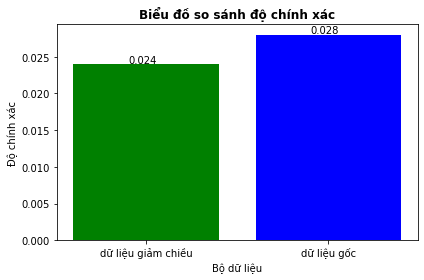

In [ ]:
y = [0.024,0.028]
x = ('dữ liệu giảm chiều','dữ liệu gốc')
plt.bar(x, y, color = ['g', 'b'])
plt.title('Biểu đồ so sánh độ chính xác', fontweight ="bold")   
plt.gcf().set_facecolor("white")
plt.xlabel('Bộ dữ liệu')
plt.ylabel('Độ chính xác')
xlocs, xlabs = plt.xticks()
for i, v in enumerate(y):
  plt.text(xlocs[i] - 0.1, v + 0.00015, v)
plt.tight_layout()